In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn import svm

from keras.datasets import mnist

# 손글씨 이미지 데이터셋 784 x 1짜리 벡터로 변환 = 28 x 28 pixel로 이루어진 손글씨 이미지
((x_train, y_train), (x_test, y_test)) = mnist.load_data()

X_train = x_train.reshape(-1,28*28)
X_test = x_test.reshape(-1,28*28)

N_train,D = X_train.shape
N_test,D = X_test.shape

# dimensional reduction (PCA)
# covariance
mu = np.mean(X_train, axis = 0)
C = X_train - mu
C = (1/N_train) * C.T.dot(C)

# SVD: C = U*S*V^T
U, s, V = np.linalg.svd(C, full_matrices = True)
S = np.diag(s)
V = V.T

# 전체 입력 차원 784 중에서, 차원을 축소해서 사용
D_reduce = 30
X_train = X_train.dot(V[:,0:D_reduce]) # N_train x D_reduce
X_test = X_test.dot(V[:,0:D_reduce]) # N_train x D_reduce
# V로 하나 U로 하나 상관 없다

X_train = np.hstack([np.ones((N_train,1)),X_train])
X_test = np.hstack([np.ones((N_test,1)),X_test])

print(X_train.shape)
# one-of-K coding
num = np.unique(y_train, axis = 0)
num = num.shape[0]

t_train = np.eye(num)[y_train]
t_test = np.eye(num)[y_test]

(60000, 31)


In [2]:
# parameter
M = np.array([X_train.shape[1],100,1000,10]) # 각 layer 뉴런들의 마다 개수

# 맨 마지막 10은 클래스 개수
L = M.shape[0] - 1
# layer 층 개수

eta = 1e-5
maxEpoch = 30

# initialize parameter
W = []
# W[0] = 31 x 100 / W[1] = 100 x 1000 / W[2] = 1000 x 10
for l in range(L):
    W.append(np.random.randn(M[l],M[l + 1]))
    print(W[l].shape)

(31, 100)
(100, 1000)
(1000, 10)


In [3]:
# activation function
def act(x):
    return np.tanh(x)

#activation fuction의 미분
def dact(x):
    return 1 - np.tanh(x)**2

#그냥 softmax 기능을 한다 정도로만 보자
# softmax, 출력 벡터다.
def softmax(x):    
    
    if x.ndim == 1:
        f_x = np.exp(x)
        return f_x / np.sum(f_x)
    
    elif x.ndim == 2:
        max = np.max(x,axis = 1,keepdims = True)
        e_x = np.exp(x - max)
        sum = np.sum(e_x,axis = 1,keepdims = True)
        f_x = e_x / sum 
        return f_x

# cross entropy
def cross_entropy(y,t):
    N,K = y.shape
    e = np.sum(- t * np.log(y), axis = 1)
    e = np.mean(e)
    
    return e

cost = []
accuracy = []

# initialize for a single input
# forward propagation
z_sample = []
# z_sample[0] = 100개 ,z_sample[1] = 1000개, z_sample[2] = 10개
a_sample = []
# z_sample과 동일

for l in range(L):    
    z_sample.append(np.zeros((1,M[l + 1])))
    a_sample.append(np.zeros((1,M[l + 1])))    
# y값을 pred_sample로 표현    
pred_sample = softmax(z_sample[-1])    

# backpropagation
delta = []
# delta == local gradient
for l in np.arange(L):    
    delta.append(np.zeros((M[l],1)))

# initialize for entire inputs
# forward propagation
z_train = []
a_train = []

# z_train[0], a_train[0] = N X 100
# z_train[1], a_train[1] = N X 1000
# z_train[2], a_train[2] = N X 10

for l in range(L):    
    z_train.append(np.zeros((N_train,M[l + 1])))
    a_train.append(np.zeros((N_train,M[l + 1])))    
pred_train = softmax(z_train[-1])    


In [4]:
# stochastic gradient descent
for epoch in range(maxEpoch):
    # 순서를 섞는 것
    N_perm = np.random.permutation(N_train)    
    W_new = W
    
    for n in range(N_train):        
              
        ### forward propagation: input layer
        # 현재 시점에서 입력값 = X_train[N_perm[n],:]
        z_sample[0] = X_train[N_perm[n],:].dot(W[0])
        a_sample[0] = act(z_sample[0])

        # propagation: 나머지 layer
        for l in range(L - 1):    
            z_sample[l + 1] = a_sample[l].dot(W[l + 1])
            a_sample[l + 1] = act(z_sample[l + 1])

        # output layer
        pred_sample = softmax(z_sample[-1])
    
        ### backpropagation
        # output layer, local gradient
        delta[L - 1] = -(t_train[N_perm[n],:] - pred_sample)

        # propagation, 각각의 local gradient 다 구함
        for l in np.arange(L - 1,1,-1):
            delta[l - 1] = W[l].dot(delta[l]) * dact(z_sample[l - 1])         
        
        # input layer, 굳이 바깥으로 빼는 이유가 있나?        
        delta[0] = W[1].dot(delta[1]) * dact(z_sample[0])

        ### update, 굳이 바깥으로 빼는 이유가 있나?
        W_new[L - 1] = W_new[L - 1] - eta*a_sample[L - 2].reshape(-1,1).dot(delta[L - 1].reshape(1,-1))
        for l in np.arange(L - 1,1,-1):
            W_new[l - 1] = W_new[l - 1] - eta*a_sample[l - 2].reshape(-1,1).dot(delta[l - 1].reshape(1,-1))  
        W_new[0] = W_new[0] - eta*X_train[N_perm[n],:].reshape(-1,1).dot(delta[0].reshape(1,-1))  
    W = W_new

    # forward propagation, 전체 샘플에 대해 진행한 것
    z_train[0] = X_train.dot(W[0])
    a_train[0] = act(z_train[0])

    for l in range(L - 1):    
        z_train[l + 1] = a_train[l].dot(W[l + 1])
        a_train[l + 1] = act(z_train[l + 1])

    pred_train = softmax(z_train[-1])

    # performance
    cost.append(cross_entropy(pred_train,t_train))
    accuracy.append(np.sum(y_train == np.argmax(pred_train, axis = 1)) / N_train)
    
    print('[epoch %d] cross entropy: %.4f, accuracy: %.4f'%(epoch,cost[-1],accuracy[-1]))  


[epoch 0] cross entropy: 22.5117, accuracy: 0.2580
[epoch 1] cross entropy: 16.1906, accuracy: 0.3719
[epoch 2] cross entropy: 11.9997, accuracy: 0.4717
[epoch 3] cross entropy: 11.4659, accuracy: 0.4807
[epoch 4] cross entropy: 9.3680, accuracy: 0.5522
[epoch 5] cross entropy: 8.8511, accuracy: 0.5575
[epoch 6] cross entropy: 8.1719, accuracy: 0.5979
[epoch 7] cross entropy: 7.5643, accuracy: 0.6212
[epoch 8] cross entropy: 7.3937, accuracy: 0.6267
[epoch 9] cross entropy: 7.2519, accuracy: 0.6311
[epoch 10] cross entropy: 6.8148, accuracy: 0.6467
[epoch 11] cross entropy: 6.6054, accuracy: 0.6519
[epoch 12] cross entropy: 6.5358, accuracy: 0.6541
[epoch 13] cross entropy: 6.1357, accuracy: 0.6643
[epoch 14] cross entropy: 6.1044, accuracy: 0.6570
[epoch 15] cross entropy: 6.2646, accuracy: 0.6484
[epoch 16] cross entropy: 5.7351, accuracy: 0.6800
[epoch 17] cross entropy: 5.6181, accuracy: 0.6835
[epoch 18] cross entropy: 5.7387, accuracy: 0.6780
[epoch 19] cross entropy: 5.5920, acc

Text(0, 0.5, 'accuracy')

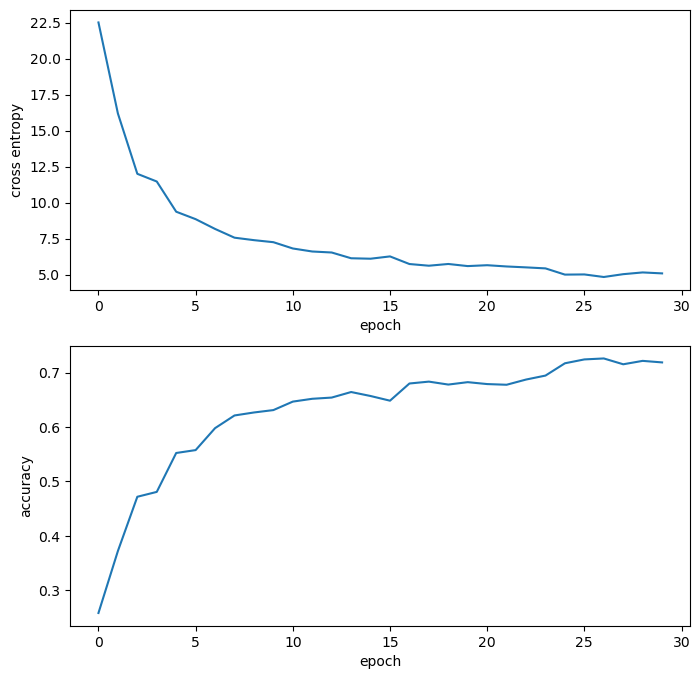

In [5]:
plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(cost)
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.subplot(2,1,2)
plt.plot(accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')